참고 사이트 
https://roytravel.tistory.com/339

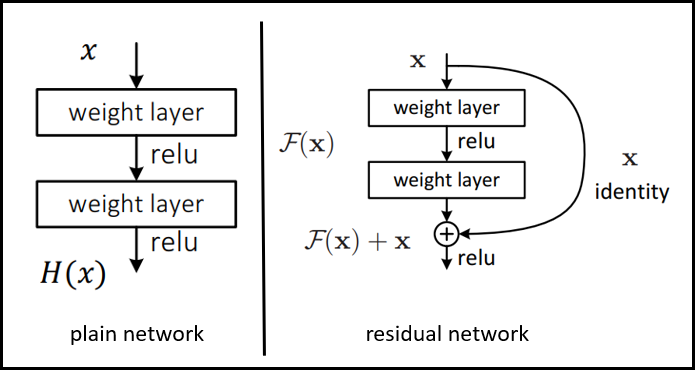

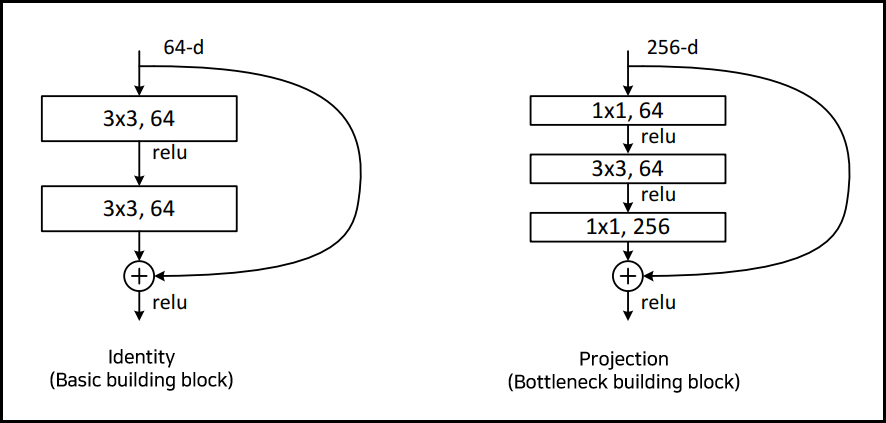
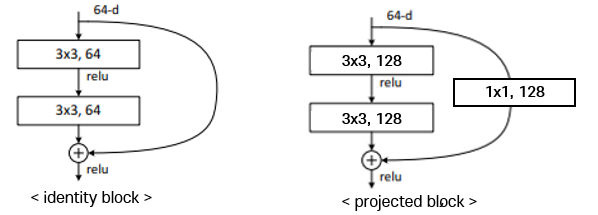

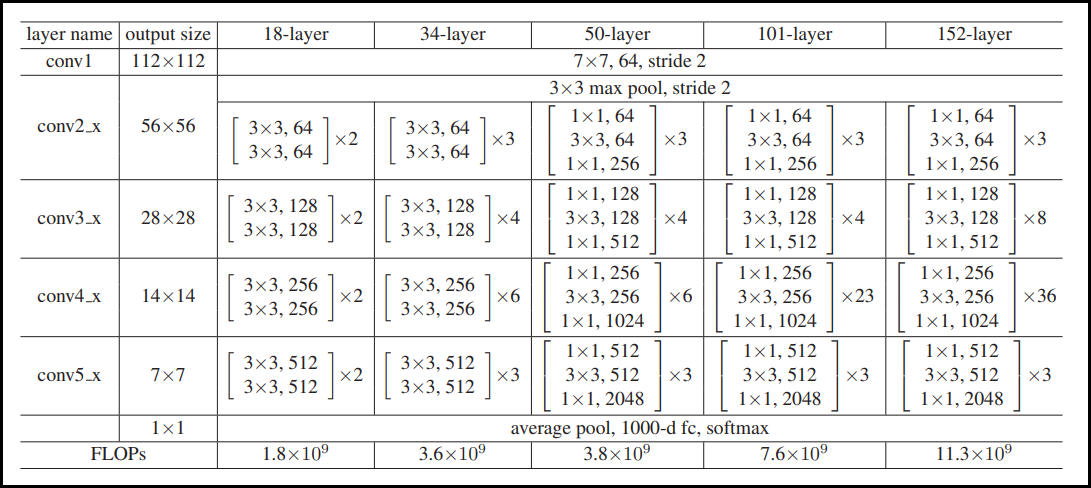

1. Augmentation

이미지를 스케일 별 augmentation을 위해 이미지 사이즈를 256~480 범위에서 랜덤 샘플링 진행
픽셀별 mean substracted을 진행하고, 224x224 이미지에 crop을 랜덤 샘플링 수행하거나 수평 플립을 적용한 이미지에서 crop을 랜덤 샘플링함
color augmentation을 사용함
 

2. Layer

Batch Normalization 적용 (convolution 이후, activation function 이전)
weight initialization 진행
Dropout 미사용
residual network에서 차원이 증가한다면 아래 두 가지 방식 적용
제로 패딩으로 차원 증가에 대응: 추가적인 파라미터 없어 좋음
1x1 convolution으로 차원 스케일링 해준 뒤 다시 원래 차원으로 스케일링 진행 
 

3. Hyper-parameter

옵티마이저: SGD 사용
배치 사이즈: 256
weight decay: 0.0001, momentum: 0.9
학습율: 0.1로 시작해서 validation error가 줄지 않으면 x10씩 줄여나감.
 iteration까지 진행되었음

In [ ]:
# identity 방식 구현
import torch
from torch import Tensor
import torch.nn as nn


class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
        self.relu2 = nn.ReLU()
        
                
    def forward(self, x: Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x += self.residual(out)
        x = self.relu2(x)
        return x

In [ ]:
# projected
class projected(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        self.relu2 = nn.ReLU()
        
                
    def forward(self, x: Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x += self.residual(out)
        x = self.relu2(x)
        return x

In [ ]:
# projection
class BottleNeck(nn.Module):
    expansion_factor = 4
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BottleNeck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion_factor)

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))
        self.relu3 = nn.ReLU()
        
    def forward(self, x:Tensor) -> Tensor:
        out = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x += self.residual(out)
        x = self.relu3(x)
        return x

In [ ]:
class ResNet(nn.Module):
    """
    ResNet 모델 구현체입니다.
    block: ResNet 블록 타입을 정의합니다 (BasicBlock 또는 Bottleneck).
    num_blocks: 각 레이어에서 사용할 블록의 수를 나타내는 배열입니다.
    num_classes: 분류할 클래스의 수입니다.
    """
    def __init__(self, block, num_blocks, num_classes=10):
        if len(num_blocks) != 4:
            raise ValueError("num_blocks 배열은 4개의 원소를 가져야 합니다.")
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        # 각 conv 레이어를 생성합니다.
        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        여러 개의 레이어를 생성하여 nn.Sequential 객체로 반환합니다.
        strides = [stride] + [1] * (num_blocks-1)
        num_blocks-1 은 num_blocks의 첫 블록을 제외한 나머지 블록의 수.
        즉, 해당 표현식은 첫 번째 블록에서는 stride 값으로 데이터의 차원을 조정하고, 
        나머지 블록들에서는 차원을 유지하면서 특징을 추출하도록 하는 stride 값들의 리스트를 생성.
        """
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """
        층의 가중치를 초기화합니다.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        """
        모델의 순전파를 정의합니다.
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# ResNet 아키텍처에 표시된 레이어의 개수를 맞춰준 모델을 반환하는 클래스를 정의
class Model:
    def resnet18(self):
        return ResNet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return ResNet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return ResNet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return ResNet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return ResNet(BottleNeck, [3, 8, 36, 3])

In [ ]:
# 간단 테스트
model = Model().resnet152()
y = model(torch.randn(1, 3, 224, 224))
print (y.size()) # torch.Size([1, 10])